
Fit Gauss1D
=========================================
In this example, we simulate a unidimensional (ground truth) MHP with an exponential kernel.

We then estimate the parameters of this MHP using ASLSD, and compare with the simulation ground-truth.


In [1]:
import os
import sys

# add the path of packages to system path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import matplotlib.pyplot as plt
import numpy as np

from aslsd.basis_kernels.basis_kernel_exponential import ExponentialKernel
from aslsd.kernels.kernel import KernelModel
from aslsd.models.mhp import MHP

We first specify our ground-truth model, and its parameter values.

In [ ]:
# Define a ground truth MHP
true_kernel = KernelModel([ExponentialKernel()])
true_mhp = MHP([[true_kernel]])

# Define true parameter values
true_mu = np.array([1.5])
true_omega = 0.2
true_beta = 1.
true_ker_param = [[np.array([true_omega, true_beta])]]

Next, we simulate a single path of this process, over a long horizon.

In [2]:
T_f = 10**6
list_times = true_mhp.simulate(T_f, mu=true_mu, kernel_param=true_ker_param,
                               seed=1234, verbose=True)

Simulating events...
Simulation Complete,  1878999  events simulated.


We next define a new mode (of the same type as the ground-truth), and estimate its parameters using the ASLSD algorithm.

In [3]:
# Define and a model
kernel = KernelModel(ExponentialKernel())
mhp = MHP([[kernel]])
kwargs = {'is_log_param': True, 'is_log_grad': True}

#Fit the parameters of the model
mhp.fit(list_times, T_f, n_iter=1000, seed=12, verbose=True, **kwargs)
fit_log = mhp.fit_log

100%|██████████| 1000/1000 [14:06<00:00,  1.18it/s]


Finally, we plot the fitted (and ground-truth) kernel, and the path of the solver.

<ipython-input-5-5819a211b42b>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


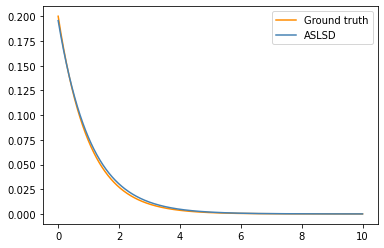

In [5]:
# Visualize results
fig = plt.figure()
t = np.linspace(0, 10, 1000)
true_y = true_mhp.phi[0][0](t, true_ker_param[0][0])
plt.plot(t, true_y, color='darkorange', label='Ground truth')
y = mhp.phi[0][0](t, mhp.fitted_ker_param[0][0])
plt.plot(t, y, color='steelblue', label='ASLSD')
plt.legend()
fig.show()

C:\git\aslsd\plots\graphic_tools.py:136: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(pad=pad)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5936C8400>,
      dtype=object)

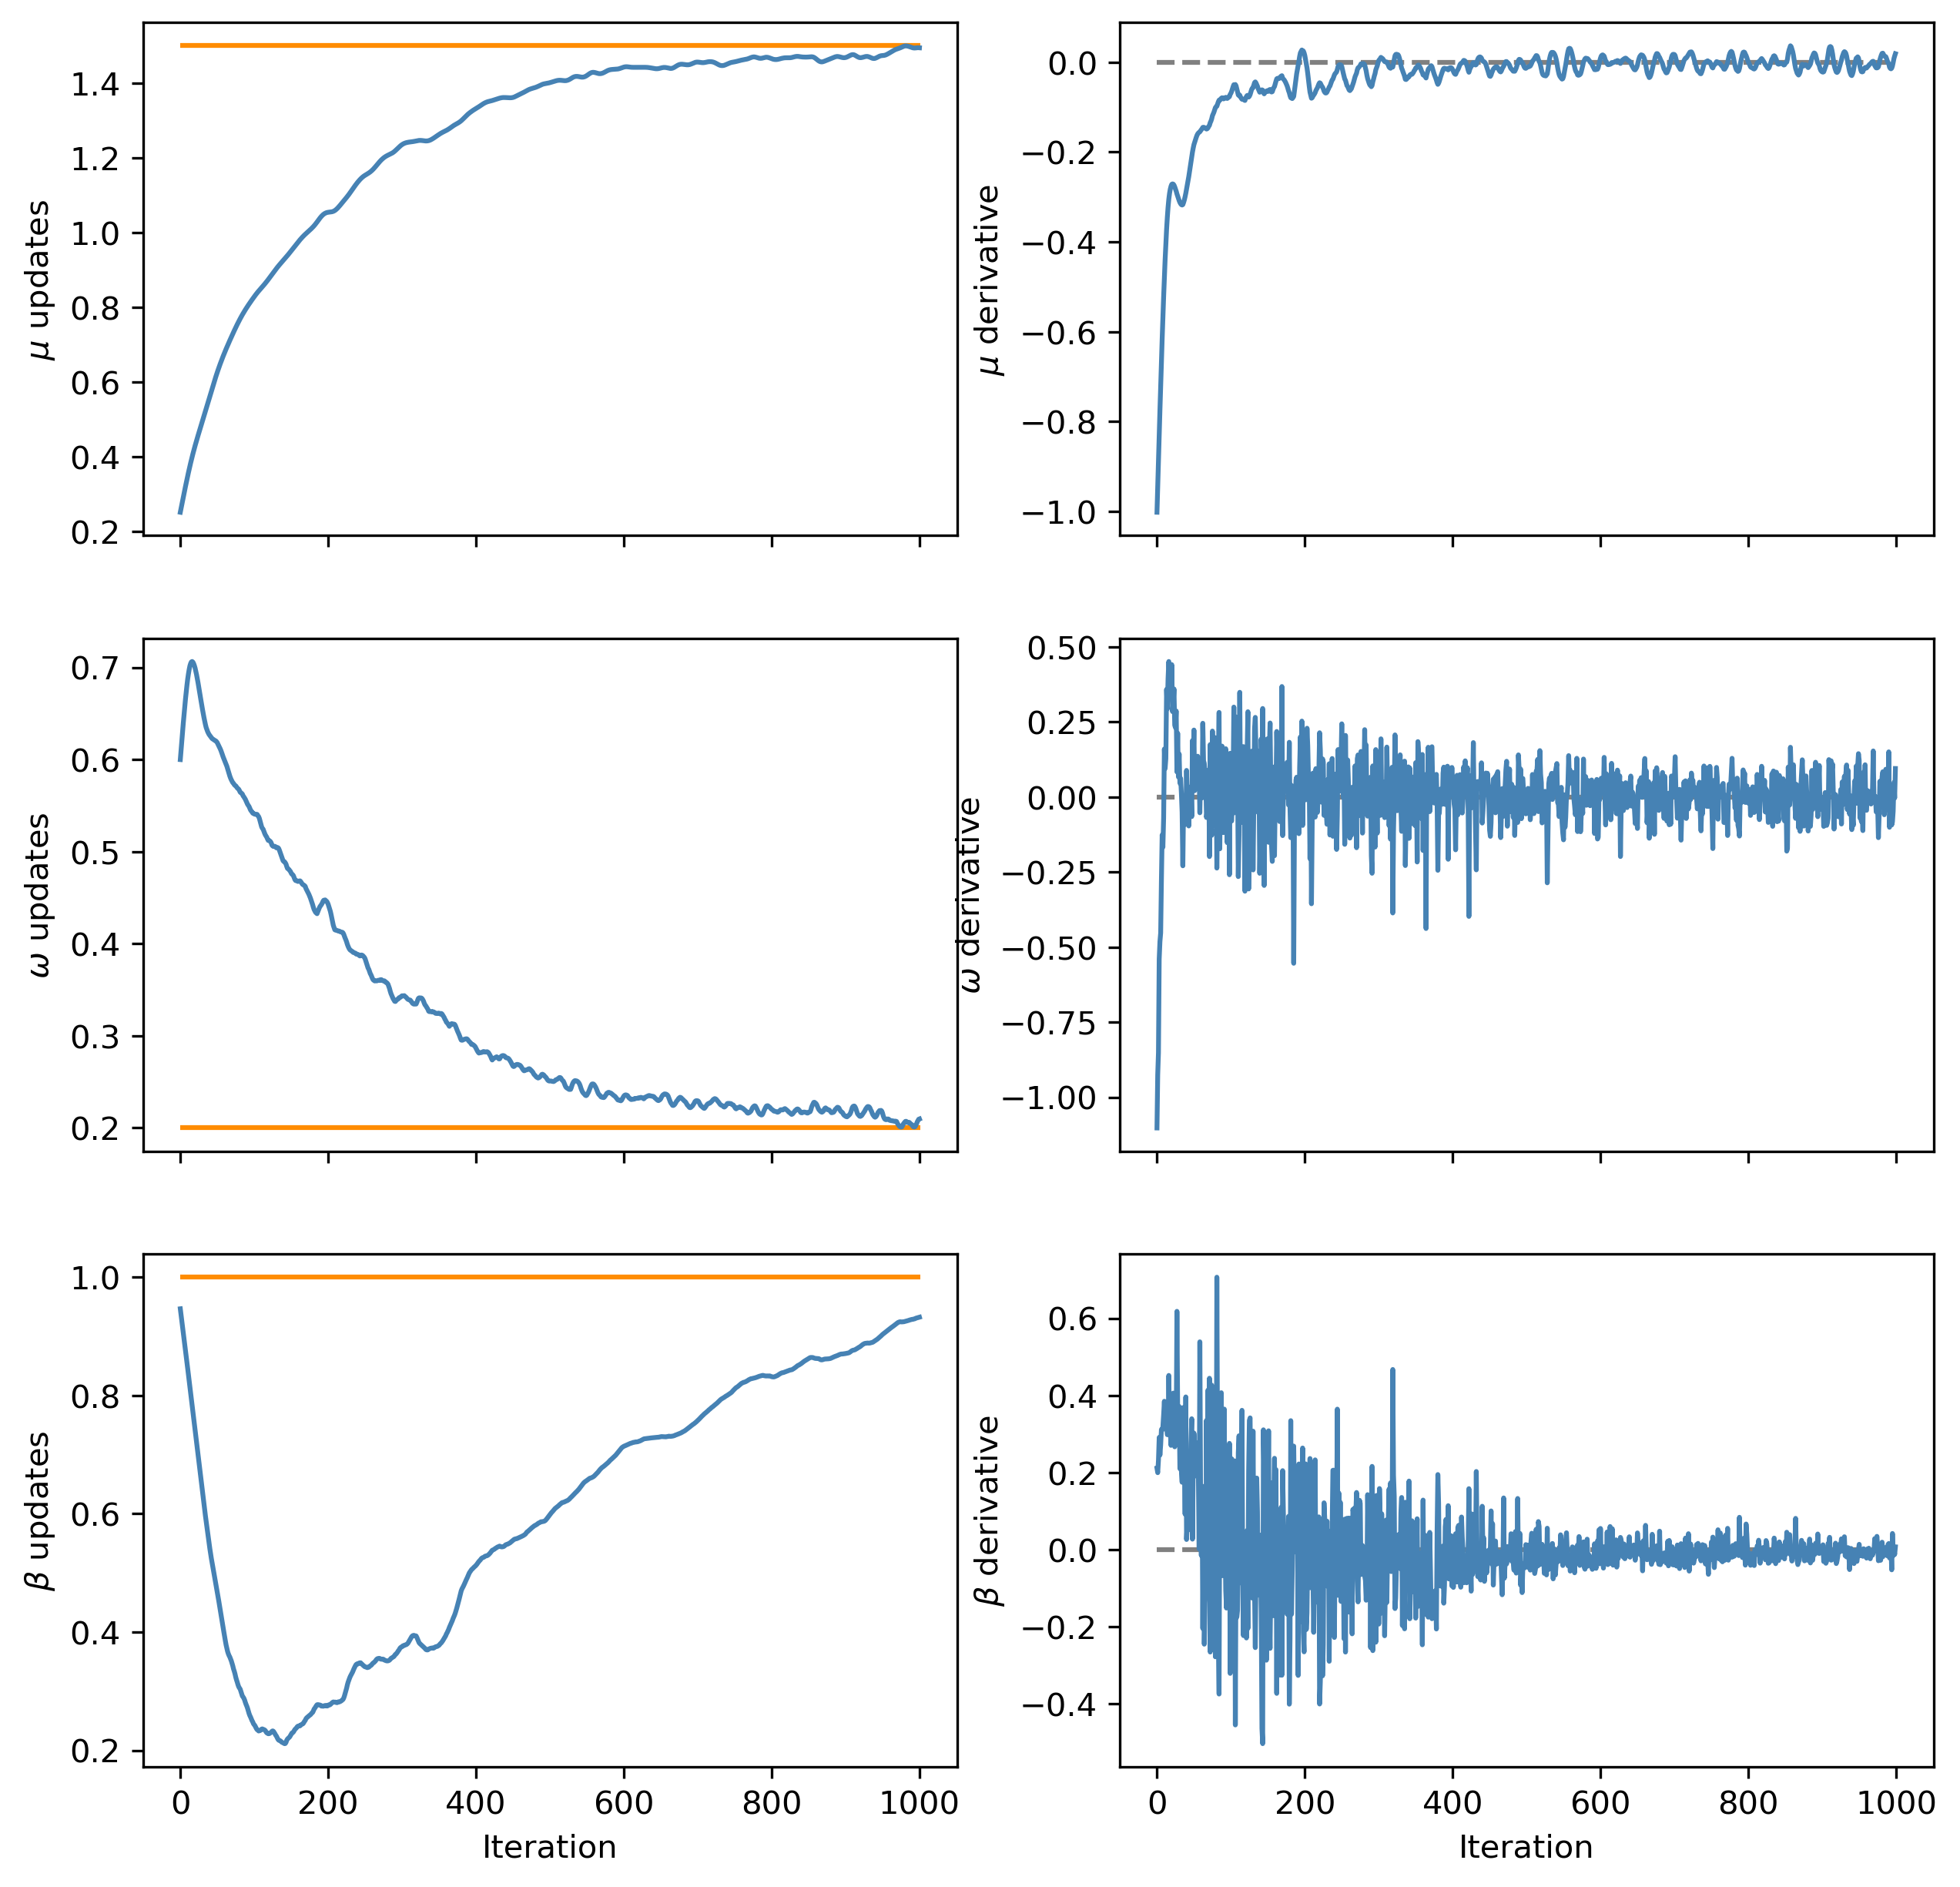

In [6]:
mhp.plot_solver_path(true_mu=true_mu, true_ker_param=true_ker_param,
                     plot_derivatives=True, derivatives_zero=True)